In [1]:
# -*- coding:utf-8 -*-

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import cross_validation
from sklearn.base import TransformerMixin

from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
stop_words = stopwords.words('english')

In [4]:
def tokenize(text):
    """ Токенизация, знаки препинания удаляются """
    text = text.lower()
    return word_tokenize(text)


def tokenize2(text):
    """ Токенизация, знаки препинания оставляются """
    text = text.lower()
    return wordpunct_tokenize(text)

In [5]:
def train_model_show_results(steps):
    """ """
    print('\nModel train')
    pipeline = Pipeline(steps=steps)

    cv_results = cross_val_score(pipeline,
                                 msg_train,
                                 label_train,
                                 cv=10,
                                 scoring='accuracy',
                                 )
    print(cv_results.mean(), cv_results.std())

    pipeline.fit(msg_train, label_train)
    label_predicted = pipeline.predict(msg_test)
    print(label_predicted)

    print(classification_report(label_test, label_predicted ))

    return pipeline, label_predicted


In [29]:
def draw_learning_curve(pipeline):
    print('Draw learning curve')
    train_sizes, train_scores, valid_scores = learning_curve(pipeline, 
                                                             msg_train, 
                                                             label_train,
                                                             train_sizes=[50, 80, 110], 
                                                             cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)

    plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [6]:
def draw_roc_curve(label_predicted):
    print('Draw roc curve')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(label_test, label_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
def length(text):
    """Длина текста."""
    return len(text)


def uppercase(text):
    """Сколько заглавных букв."""
    return len([letter for letter in list(text) if letter.isupper()])


def exclamation(text):
    """Сколько !."""
    return len([letter for letter in list(text) if letter == '!'])


def numbers(text):
    """Сколько чисел."""
    return len([letter for letter in list(text) if letter.isdigit()])


def warning_words(text):
    """Сколько слов, типичных для спам-сообщений."""
    return len([word for word in tokenize(text) if word in spam_words])


class FunctionFeaturizer(TransformerMixin):
    """ Для создания своего вектора я использовала несколько фич: длину текста, количество заглавных букв
     (чем больше, тем обычно выше вероятность, что это спам), количество ! (в спам-сообщениях встречаются часто),
     количество чисел, сколько слов из словаря спам-слов (50 самых частых слов в коллекции спам-сообщений)"""
    def __init__(self, *featurizers):
        self.featurizers = featurizers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fvs = []
        for datum in X:
            fv = [f(datum) for f in self.featurizers]
            fvs.append(fv)
        return np.array(fvs)


In [41]:
spam_featurizer = FunctionFeaturizer(length, uppercase, exclamation, numbers,warning_words)  # создание своего векторизатора

path = 'smsspamcollection/SMSSpamCollection'

# Чтение из файла
messages = pandas.read_csv(path, sep='\t', 
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [45]:
# Ститастика по словам, которые встречаются в спам-сообщениях
from collections import Counter
list1 =[]
for m in messages.message[messages.label=='spam']:
    for word in tokenize(m):
        list1.append(word)
counts = Counter(list1)

In [51]:
counts.most_common(50)

[('.', 924),
 ('to', 690),
 ('!', 545),
 (',', 378),
 ('a', 377),
 ('call', 346),
 ('you', 297),
 ('your', 263),
 ('free', 217),
 ('the', 206),
 ('for', 203),
 ('now', 199),
 ('or', 188),
 ('&', 178),
 ('?', 175),
 ('2', 174),
 (':', 163),
 ('is', 158),
 ('txt', 156),
 ('on', 145),
 ('ur', 144),
 ('u', 141),
 ('have', 136),
 ('from', 131),
 ('mobile', 123),
 ('and', 122),
 ('text', 121),
 ('stop', 118),
 ('claim', 113),
 ('with', 109),
 ('reply', 104),
 ('4', 95),
 ('of', 95),
 ('prize', 92),
 ('this', 88),
 ('our', 85),
 ('get', 84),
 ('are', 80),
 ('just', 79),
 ('only', 79),
 ('won', 73),
 ('in', 73),
 ("'s", 72),
 ('new', 69),
 ('send', 69),
 ('t', 68),
 (')', 66),
 ('nokia', 65),
 ('urgent', 63),
 ('cash', 62)]

1(+6). Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?

In [18]:
messages.groupby('label').describe()

length
label                   
ham   count  4825.000000
      mean     71.482487
      std      58.440652
      min       2.000000
      25%      33.000000
      50%      52.000000
      75%      93.000000
      max     910.000000
spam  count   747.000000
      mean    138.670683
      std      28.873603
      min      13.000000
      25%     133.000000
      50%     149.000000
      75%     157.000000
      max     223.000000

Выборка несбалансированна, неспам - 4825, спам - 747, примеров спама гораздо меньше

In [19]:
# перевод str в int (ham->0, spam->1)
messages['label'] = messages['label'].map({'ham': 0, 'spam': 1}).astype(int)

In [20]:
#  Поделить выборку в соотновении 80:20
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

In [26]:
# Векторизация
bow = CountVectorizer()
bow.fit_transform(msg_train)
train_bowed_messages = bow.transform(msg_train)
test_bowed_messages = bow.transform(msg_test)

In [27]:
# Обучение DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(train_bowed_messages, label_train)

# Вывод результатов по Dummy Classifier
print(classification_report(label_test, clf.predict(test_bowed_messages)))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92       947
          1       0.00      0.00      0.00       168

avg / total       0.72      0.85      0.78      1115



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dummy classifier, который будет всем новым наблюдениям присваивать класс ham, получит 75% precission и 87 -  recall, 80 - f-score. Precision и recall у спамовых сообщений - 0, Dummy Classifier плохо справляется с задачей определения спамовых сообщений

In [30]:
print('\nNaive Bayes 1')
naive_model = MultinomialNB()
naive_model.fit(train_bowed_messages, label_train)

cv_results = cross_val_score(naive_model, test_bowed_messages, label_test, cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())
print(classification_report(label_test, naive_model.predict(test_bowed_messages)))


Naive Bayes 1
0.9721998947 0.0157637103722
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       947
          1       0.99      0.93      0.96       168

avg / total       0.99      0.99      0.99      1115



Naive Bayes,  tokenize 1

Model train
0.984965465541 0.00585837770827
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       947
          1       0.97      0.92      0.94       168

avg / total       0.98      0.98      0.98      1115

Draw learning curve


/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


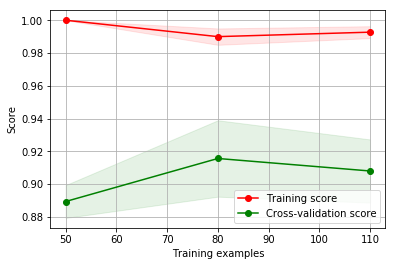

Draw roc curve


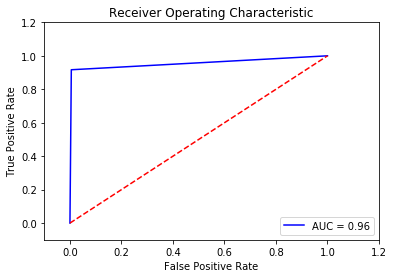

In [31]:
# Первая токенизация, Байес
print('Naive Bayes,  tokenize 1')
pipeline, label_predicted = train_model_show_results(steps=[
        ('bow', CountVectorizer(analyzer=tokenize)),
        ('classifier', MultinomialNB())
    ])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)

Судя по roc-curve, классификатор показывает высокие результаты, AUC-value очень высокий, roc-curve почти параллельна оси х. Learning curve показывает, что при увеличении обучающих данных, cross-validation score может незначительно улучшиться, training score при этом немного ухудшится.

In [32]:
# Вторая токенизация, Байес
print('Naive Bayes tokenize 2')
pipeline, label_predicted = train_model_show_results(steps=[
        ('bow', CountVectorizer(analyzer=tokenize2)),
        ('classifier', MultinomialNB())
    ])

Naive Bayes tokenize 2

Model train
0.989228582893 0.00519702055836
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       947
          1       0.99      0.95      0.97       168

avg / total       0.99      0.99      0.99      1115



Значения точности и полноты при определении спама очень высокие, если классификатор показал спам, то мы с 98% точностью можем быть уверены, чио это спам. При этом полнота определния спама - 91%, это значит, что классификатор отловил 91% спамовых сообщений.

In [33]:
# Первая токенизация, Байес, удаляем стоп слова
print('Naive Bayes удаляем стоп слова')
pipeline, label_predicted = train_model_show_results(steps=[
        ('bow', CountVectorizer(analyzer=tokenize, stop_words=stop_words)),
        ('classifier', MultinomialNB())
    ])


Naive Bayes удаляем стоп слова

Model train
0.984965465541 0.00585837770827
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       947
          1       0.97      0.92      0.94       168

avg / total       0.98      0.98      0.98      1115



Значения точности и полноты при определении спама очень высокие, если классификатор показал спам, то мы с 98% точностью можем быть уверены, чио это спам. При этом полнота определния спама - 87%, это значит, что классификатор отловил 87% спамовых сообщений.

In [34]:
# Байес, векторизация tf-idf
print('Векторизация tf-idf')
pipeline, label_predicted = train_model_show_results(steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
    ])


Векторизация tf-idf

Model train
0.958491924937 0.00652243107525
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       947
          1       1.00      0.71      0.83       168

avg / total       0.96      0.96      0.95      1115



Значения точности и полноты при определении спама очень высокие, если классификатор показал спам, то это 100% спам. При этом полнота определния спама не очень высокая - 70%, это значит, что классификатор отловил спам только в 70% случаях.

In [35]:
# Байес, векторизация tf-idf, fit_prior=False
print('Векторизация tf-idf, fit_prior=False')
pipeline, label_predicted = train_model_show_results(steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB(fit_prior=False))
    ])


Векторизация tf-idf, fit_prior=False

Model train
0.978234468912 0.00402936776817
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       947
          1       0.96      0.92      0.94       168

avg / total       0.98      0.98      0.98      1115



Decission Tree

Model train
0.961405706356 0.0130785190293
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       947
          1       0.92      0.86      0.89       168

avg / total       0.97      0.97      0.97      1115

Draw learning curve


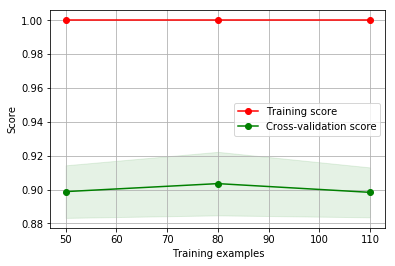

Draw roc curve


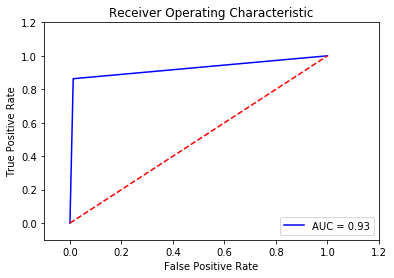

In [36]:
# Дерево принятий решений, tf-idf
print('Decission Tree')
pipeline, label_predicted = train_model_show_results(steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', DecisionTreeClassifier())
    ])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)

Learning curve показывает, что при увеличении обучающих данных, cross-validation score может незначительно улучшиться, training score при этом останется статичен.
Судя по roc-curve, классификатор показывает высокие результаты, но у наивного байесы было лучше (надо смотреть на наклон синей прямой). AUC-value хуже, чем у Байеса, лучше, чем у случайного леса.

RandomForestClassifier

Model train
0.969934467142 0.00611808940788
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       947
          1       1.00      0.77      0.87       168

avg / total       0.97      0.97      0.96      1115

Draw learning curve


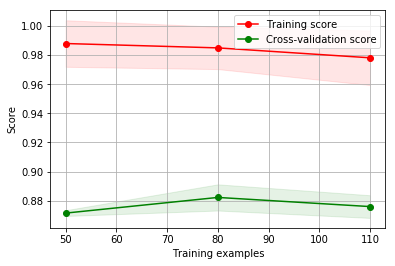

Draw roc curve


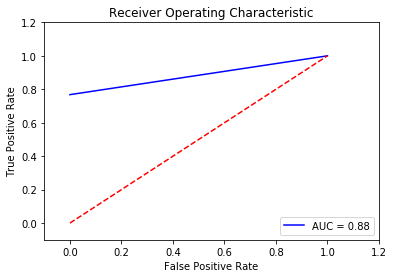

In [37]:
# Случайный лес, tf-idf
print('RandomForestClassifier')
pipeline, label_predicted = train_model_show_results(steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', RandomForestClassifier())
    ])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)


Learning curve показывает, что при увеличение обучающих данных практически ничего не даст.
AUC-value равен достаточно высокий, но хуже, чем у наивного байеса и случайного леса

Custom Transformer

Model train
0.950634795374 0.00883123498
[0 0 0 ..., 0 0 0]
             precision    recall  f1-score   support

          0       0.98      0.95      0.97       947
          1       0.77      0.89      0.82       168

avg / total       0.95      0.94      0.94      1115

Draw learning curve


/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


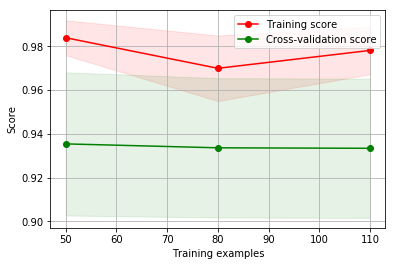

Draw roc curve


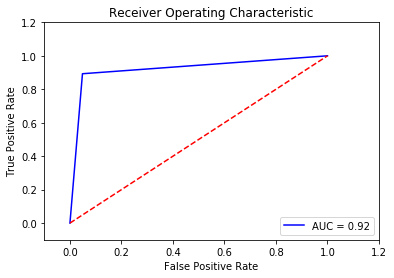

In [38]:
# Свой векторизатор
print('Custom Transformer')
pipeline, label_predicted = train_model_show_results(steps=[
        ('custom', spam_featurizer),
        ('classifier', MultinomialNB())
    ])

draw_learning_curve(pipeline)
draw_roc_curve(label_predicted)


Все вышеописанные классификаторы дают достаточно высокие результаты. fit_prior=False результаты не улучшает.
У Random forest самый высокий Precision у 1. 
Наивный Байес дал лучшие результаты, чем случайный лес и дерево решений